In [3]:
import json

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.patches as ptchsa
import matplotlib.pyplot as plt
import matplotlib.text as mtext
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import scipy.integrate
import scipy.optimize
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

# from sklearn.linear_model import Ridge
from mpl_toolkits.mplot3d import Axes3D
from pandas.core.base import PandasObject

In [4]:
uvablack = "#1f1d21"
rootblue = "#346295"
roothighlight = "#27D0E5"
uvared = "#BC0031"
uvagray = "#808080"
vublue = "#0077B3"
vugreen = "#008053"
vuorange = "#CC4100"
pcspurple = "#3F51B5"

pred_color = uvablack
pred_style = {
    "marker": "s",
    "color": pred_color,
    "markersize": 7,
    "markerfacecolor": "none",
    "ls": "--",
}
pred_nocolor_style = {
    "marker": "s",
    "markersize": 7,
    "markerfacecolor": "none",
    "ls": "--",
}
sum_style = {"marker": "s", "markersize": 7, "ls": ":"}
bm_style = {"marker": "s", "markersize": 5}
vd_style = {"marker": "s", "markersize": 7}
sl_style = {"marker": "o", "color": "k", "ms": 14, "markerfacecolor": "None", "ls": ""}

# colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']
colors = [
    rootblue,
    vuorange,
    # "#F17105", # orange
    roothighlight,
    uvared,
    # pccspurple,
    "#AB81CD",  # lavender
    vugreen,
    # "#6BD425", # sgbus green
    uvagray,
    # "#0077B3", # vublue
]
ecolors = ["b", "r", vublue, "#5C0F3D", "purple", "g", uvablack]

# ecolors=["b", "r", "g", "brown"]
mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=colors)
mpl.rcParams.update({"axes.grid": True})
plt.rcParams["ytick.minor.visible"] = True
# mpl.rcParams.update({"axes.grid" : True})
# yaxis.set_minor_locator(MinorSymLogLocator(1e-1))

# import mplhep as hep
# hep.style.use(hep.style.ROOT) # For now ROOT defaults to CMS


class LegendTitle(object):
    def __init__(self, text_props=None):
        self.text_props = text_props or {}
        super(LegendTitle, self).__init__()

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        title = mtext.Text(
            x0, y0, r"\textbf{" + orig_handle + "}", usetex=True, **self.text_props
        )
        handlebox.add_artist(title)
        return title


class LightLegendTitle(object):
    def __init__(self, text_props=None):
        self.text_props = text_props or {}
        super(LightLegendTitle, self).__init__()

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        title = mtext.Text(x0, y0, orig_handle, usetex=True, **self.text_props)
        handlebox.add_artist(title)
        return title


def fill_between_edges(ax, X, ymin, ymax, facecolor, edgecolor, label="", **kwargs):
    ax.fill_between(X, ymin, ymax, alpha=0.8, color=facecolor, zorder=100, **kwargs)
    ax.fill_between(
        X, ymin, ymax, facecolor="none", edgecolors=edgecolor, zorder=100, **kwargs
    )
    ax.add_patch(
        ptchs.Rectangle(
            (0, 0), 0, 0, facecolor=facecolor, edgecolor=edgecolor, label=label
        )
    )


def plot_validation_labels():
    plt.plot(0, 0, label="Measured runtime", c="k", **bm_style)
    plt.plot(0, 0, label="Model prediction", c="k", **pred_nocolor_style)


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        "trunc({n},{a:.2f},{b:.2f})".format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)),
    )
    return new_cmap

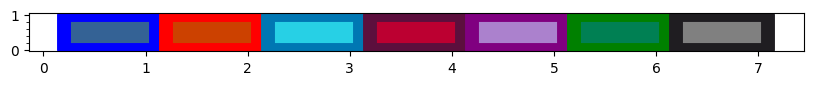

In [5]:
plt.figure(figsize=(10, 0.5))
ax = plt.subplot(111)
for i, (c, ec) in enumerate(zip(colors, ecolors)):
    ax.fill_between(
        [i + 0.2, i + 1 + 0.1], 0, 1, facecolor=c, edgecolor=ec, label="???", lw=10
    )
plt.grid()
plt.show();

In [6]:
class MinorSymLogLocator(ticker.Locator):
    """
    Dynamically find minor tick positions based on the positions of
    major ticks for a symlog scaling.
    """

    def __init__(self, linthresh, nints=10):
        """
        Ticks will be placed between the major ticks.
        The placement is linear for x between -linthresh and linthresh,
        otherwise its logarithmically. nints gives the number of
        intervals that will be bounded by the minor ticks.
        """
        self.linthresh = linthresh
        self.nintervals = nints

    def __call__(self):
        # Return the locations of the ticks
        majorlocs = self.axis.get_majorticklocs()

        if len(majorlocs) == 1:
            return self.raise_if_exceeds(np.array([]))

        # add temporary major tick locs at either end of the current range
        # to fill in minor tick gaps
        dmlower = majorlocs[1] - majorlocs[0]  # major tick difference at lower end
        dmupper = majorlocs[-1] - majorlocs[-2]  # major tick difference at upper end

        # add temporary major tick location at the lower end
        if majorlocs[0] != 0.0 and (
            (majorlocs[0] != self.linthresh and dmlower > self.linthresh)
            or (dmlower == self.linthresh and majorlocs[0] < 0)
        ):
            majorlocs = np.insert(majorlocs, 0, majorlocs[0] * 10.0)
        else:
            majorlocs = np.insert(majorlocs, 0, majorlocs[0] - self.linthresh)

        # add temporary major tick location at the upper end
        if majorlocs[-1] != 0.0 and (
            (np.abs(majorlocs[-1]) != self.linthresh and dmupper > self.linthresh)
            or (dmupper == self.linthresh and majorlocs[-1] > 0)
        ):
            majorlocs = np.append(majorlocs, majorlocs[-1] * 10.0)
        else:
            majorlocs = np.append(majorlocs, majorlocs[-1] + self.linthresh)

        # iterate through minor locs
        minorlocs = []

        # handle the lowest part
        for i in range(1, len(majorlocs)):
            majorstep = majorlocs[i] - majorlocs[i - 1]
            if abs(majorlocs[i - 1] + majorstep / 2) < self.linthresh:
                ndivs = self.nintervals
            else:
                ndivs = self.nintervals - 1.0

            minorstep = majorstep / ndivs
            locs = np.arange(majorlocs[i - 1], majorlocs[i], minorstep)[1:]
            minorlocs.extend(locs)

        return self.raise_if_exceeds(np.array(minorlocs))

    def tick_values(self, vmin, vmax):
        raise NotImplementedError(
            "Cannot get tick locations for a " "%s type." % type(self)
        )


import ROOT

ROOT.gROOT.ProcessLine("gErrorIgnoreLevel = kError;")
ROOT.gStyle.SetCanvasDefW(2400)
ROOT.gStyle.SetCanvasDefH(900)
ROOT.gStyle.SetLegendTextSize(0.05)
ROOT.gStyle.SetLabelSize(0.05)
ROOT.gStyle.SetMarkerSize(1)
ROOT.gStyle.SetMarkerStyle(8)
ROOT.gStyle.SetLineWidth(2)
ROOT.gStyle.SetTextFont(42)
ROOT.gStyle.SetTextSize(0.05)
ROOT.gStyle.SetTickLength(0.02, "y")
ROOT.gStyle.SetHatchesSpacing(1)  # to define the spacing between hatches.
ROOT.gStyle.SetHatchesLineWidth(1)  # to define the hatches line width.


def get_symlog_bins(max_val, base):
    max_exp = np.ceil(np.log(max_val) / np.log(base))
    a = np.append(0, np.power(base, np.arange(max_exp + 1)))

    s = 3  # number of intervals between two numbers
    l = (a.size - 1) * s + 1  # total length after interpolation
    return np.interp(np.arange(l), np.arange(l, step=s), a)  # interpolate

In [7]:
def convert_to_type(df, col, type):
    df[col] = df[col].apply(lambda s: type(s) if pd.notnull(s) else s)


def normalize_df(df, cols, norm):
    for col in cols:
        df[col] = df[col].div(df[norm])


def unique_non_nan(df):
    return df.dropna().unique()


PandasObject.unique_non_nan = unique_non_nan


def map_distr_name(distr):
    s = distr.split("-")
    n = distr
    if "constant" in distr:
        n = f"{s[0]}({s[1]})"
    elif "normal" in distr:
        n = f"{s[0]}({s[1]}, {s[2]})"
    return n.title()


def human_readable(val, bytes=False):
    if bytes:
        factor = 1024
        if int(val / pow(factor, 3)) > 0:
            return f"{int(val/pow(factor, 3))}GB"
        elif int(val / pow(factor, 2)) > 0:
            return f"{int(val/pow(factor, 2))}MB"
        elif int(val / pow(factor, 1)) > 0:
            return f"{int(val/pow(factor, 1))}KB"
        else:
            return str(int(val))
    else:
        factor = 1e3
        if int(val / pow(factor, 3)) > 0:
            return f"{int(val/pow(factor, 3))}B"
        elif int(val / pow(factor, 2)) > 0:
            return f"{int(val/pow(factor, 2))}M"
        elif int(val / pow(factor, 1)) > 0:
            return f"{int(val/pow(factor, 1))}K"
        else:
            return str(int(val))

def convert_time_unit(x):
    """
    Get factor to convert to seconds
    """
    if x == "s":
        return 1
    elif x == "ms":
        return 1e3
    elif x == "us":
        return 1e6
    elif x == "ns":
        return 1e9


def convert_data_unit(x):
    """
    Get factor to convert to bytes
    """
    if x == "b":
        return 1
    elif x == "kb":
        return 1024
    elif x == "mb":
        return 1024 * 1024
    elif x == "gb":
        return 1024 * 1024 * 1024


def unit_to_unit_factor(u1, u2, bytes=False):
    if bytes:
        f2 = convert_data_unit(u1)
        f1 = convert_data_unit(u2)
    else:
        f1 = convert_time_unit(u1)
        f2 = convert_time_unit(u2)
    return f2 / f1


def map_env(e):
    if e == "CUDA_HIST":
        return "CUDA"
    elif e == "AdaptiveCpp":
        return "ACPP"
    return e


def mae(pred, observ):
    return np.sum(np.abs(pred - observ)) / len(pred)


def r2(pred, observ):
    return 1 - (
        np.sum(np.power(pred - observ, 2))
        / np.sum(np.power(observ - np.mean(observ), 2))
    )

In [10]:
def lower_bound(a, v):
    first = 0
    count = len(a)
    last = count - 1
    acc = np.zeros(len(a))
    indices = []

    while count > 0:
        it = first
        step = int(count / 2)
        it += step

        acc[it] += 1
        indices.append(it)

        if a[it] < v:
            it += 1
            first = it
            count -= step + 1
        else:
            count = step
    return first, acc, indices


def get_subsize(distr, nbins):
    """
    Calculate  based on the distribution type and number of bins.

    Parameters:
    - distr (str): The distribution type, e.g., "constant", "uniform", or "normal-mu-sigma".
    - nbins (int, list): Number of bins or a list of bin counts for which subsize needs to be calculated.

    Returns:
    - subsize (int, list): Calculated subsize based on the distribution type and number of bins.

    Notes:
    - If distr is "constant", subsize is an array of 1s with the same length as nbins.
    - If distr is "uniform", subsize is a list if nbins is a list, otherwise, it's an array of nbins.
    - If distr is "normal-mu-sigma", subsize is calculated based on the normal distribution with mean (mu) and
      standard deviation (sigma). If nbins is a list, it calculates subsize for each bin count in the list.
    """
    if "constant" in distr:
        subsize = np.power(nbins, 0)
    elif "uniform" in distr:
        subsize = nbins
    elif "normal" in distr:
        mu = np.float64(distr.split("-")[1])
        sigma = np.float64(distr.split("-")[2])
        xmin = mu - 1 * sigma
        xmax = mu + 1 * sigma
        subsize = []
        try:
            for nb in nbins:
                a = np.arange(nb) / nb
                subsize.append(lower_bound(a, xmax)[0] - lower_bound(a, xmin)[0])
        except:
            a = np.arange(nbins) / nbins
            subsize = lower_bound(a, xmax)[0] - lower_bound(a, xmin)[0]
    return subsize


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [9]:
def filter_name(n):
    # print(n)
    name_map = {
        "Stats": "UpdateStats",
        "Reduce": "UpdateStats",
        "Histo": "FindBin + AddBinContent",
        "ExcludeUOverflowKernel": "Other",
        "InitializeToZeroTask": "Other",
        "Host-to-Device": "HtoD",
        "Device-to-Host": "DtoH",
        "CUDAmemset": "Memset",
    }
    for w in [
        "unsigned",
        "int",
        "char",
        "float",
        "void",
        "const",
        "long",
        "*",
        "hipsycl_kernel",
        "::operator",
        "ROOT::",
        "Experimental::",
        "_",
        "::",
        "]",
        "[",
        "  ",
    ]:
        n = n.replace(w, "")
    for k, v in name_map.items():
        if k in n:
            n = v

    return n.strip()


def get_cell(df, index_name, col):
    return df.loc[index_name][col]


def fill_bar(h, x, w, d, c, s):
    h.Fill(x, w)
    h.SetBinError(h.FindBin(x), d)
    if s:
        h.SetFillStyle(s)
    h.SetLineColor(c)
    h.SetFillColor(c)
    h.SetLineWidth(2)
    h.SetMarkerSize(0)


# default_clr = ROOT.kGray+2
def get_group(n):
    if n in [
        "cuModuleLoadDataEx",
        "cuModuleUnload",
        "cuModuleGetLoadingMode",
        "cuCtxSetCurrent",
    ]:
        return "Module"
    elif n in [
        "cuEventCreate",
        "cuEventDestroy_v2",
        "cuEventQuery",
        "cuEventRecord",
        "cuEventSynchronize",
        "cudaEventCreate",
        "cudaEventDestroy",
        "cudaEventRecord",
        "cudaEventSynchronize",
    ]:
        return "Event"
    elif n in [
        "cuMemAlloc_v2",
        "cuMemFree_v2",
        "cuMemcpyAsync",
        "cuMemcpyHtoDAsync_v2",
        "cuMemcpyDtoHAsync_v2",
        "cuMemsetAsync",
        "cudaMalloc",
        "cudaFree",
        "cudaMemcpyAsync",
        "cudaMemsetAsync",
        "cuMemsetD8Async",
        "CUDAMalloc",
        "CUDAFree",
        "cudaMemcpy",
        "cudaMemset",
    ]:
        return "Memory"
    elif n in [
        "cuStreamWaitEvent",
        "cuStreamCreateWithPriority",
        "cuStreamDestroy_v2",
        "cuStreamCreateWithFlags",
        "cudaStreamCreateWithFlags",
        "cudaStreamDestroy",
        "cudaStreamWaitEvent",
        "cuStreamSynchronize",
    ]:
        return "Stream"
    elif n in [
        "cuLaunchKernel",
        "cudaLaunchKernel",
        "CUDALaunchKernel",
    ]:
        return "Kernel"
    elif n in [
        "cuGetDevicePropertiesv2v12000",
        "cudaGetDeviceProperties_v2_v12000",
    ]:
        return "Properties"